

Para el desarrollo de esté taller se llevará a cabo la metodología CRISP-DM la cuál es implementada en la industria para llevar a cabo proyectos de Machine Learning. Se hará uso de Google Colab para ejecutar código python; presenta la misma funcionalidad de Jupyter Notebook de Anaconda, la única diferencia es que en google colab no se pueden crear Enviroment destinados a cada proyecto, .


Para esté tipo de ejercicios lo ideal es tomar una porción de datos (10%), del dataset para hacer pruebas con auquellos datos que el modelo no ha visto.


**Se utiliza la metodología Crisp DM:**

1. Entender el negocio
2. Entender los datos, que variables tengo, que variables me sirven
3. Procesar los datos, eliminar outliers, tratamiento de Nulos
4. Elegir y desarrollar el modelo 
5. Colocar el modelo en producción (no aplica en este caso)


# 1. Entender el negocio y el objetivo 

**Objetivo del negocio:** Automatizar la detección de **fallos** en baterías 

**Requerimiento Técnico** : Construir un modelo de clasificación de machine learning para detectar los **fallos** en las baterías.



Las celdas de energía son dispositivos que se utilizan en hospitales en ciertos equipos especiales, estas celdas generan información en tiempo real (temperatura, corriente, resistencia, voltaje) si uno de los parámetros esta fuera del rango normal es posible que se produzca una fallo en la celda y por tanto en el equipo. Se requiere entrenar un modelo de Machine Learning que aprenda a identificar un fallo, clasificando los datos de entrada en los tres estados (ok, alerta, error)

Se están midiendo 3 variables importantes (amp,vcd e imp) que ayuda a definir el estado de la celda. Esto es importante para la toma deciones para evitar una falla de la carga, en este caso los equipos, con el fin de garantizar la disponibilidad y la confiabilidad del servicio.


**Diccionario de variables**

**- amp**: Es la corriente medida en amperios, que se traduce en la cantidad de electrones que circulan x un conductor

**- vcd**: Es el voltaje, que se define como la presión de los electrones al tratar de circular.

**- imp** : La resistencia se mide en omnios, y se define como una medida de oposición al flujo de corriente en un circuito. Cuando mayor sea la resistencia, menor será el flujo de corriente.

**- tmp** : Nivel tértmico de un objeto.



# 2. Exploración de Datos

Lo primero que se debe hacer es importar las librerías que serán usadas durante el desarrollo de la prueba

In [ ]:
import pandas as pd
import numpy as np
import io
from google.colab import files
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import validation_curve
from sklearn import preprocessing
import itertools
from scipy.stats import skewtest, levene
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.semi_supervised import LabelPropagation
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import RidgeClassifier


from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_predict
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,VotingClassifier,ExtraTreesClassifier,GradientBoostingClassifier
from sklearn.metrics import classification_report,plot_confusion_matrix,confusion_matrix,recall_score


In [ ]:
# Se carga el archivo desde la ruta local del PC
uploaded = files.upload()

Saving baterias-datos.csv to baterias-datos (1).csv


In [ ]:
# se lee el archivo csv, usando pandas: baterias-datos.csv, Luego se crea el dataframe a partir del archivo
archivo = io.BytesIO(uploaded['baterias-datos.csv'])
df_baterias=pd.read_csv('baterias-datos.csv',sep=';',decimal=',')

Antes de continuar con el ejercicio se hace una muestra de los datos del 10% que se usara en la etapa de la validación del modelo.

In [ ]:
df_baterias_val = df_baterias.sample(frac=0.1)

Al dataframe que vamos a usar para el desarrollo del modelo de machine learning, se le debe quitar el 10% de los datos que estamos separando para el tema de validación

In [ ]:
df_baterias = df_baterias.loc[~df_baterias.index.isin(df_baterias_val.index)]

In [ ]:
# Se realiza una muestra del archivo
df_baterias.head()

,vcd,amp,tmp,imp,estado_id,estado
0,14.30,68.52,13.83,39.19,0,ok
1,14.48,86.92,12.75,32.74,0,ok
2,14.18,80.65,5.27,27.58,0,ok
3,13.68,56.30,13.96,17.91,0,ok
4,13.67,61.49,7.71,26.40,0,ok


In [ ]:
# Se verifica las columnas existentes en el dataframe
df_baterias.columns

Index(['vcd', 'amp', 'tmp', 'imp', 'estado_id', 'estado'], dtype='object')

In [ ]:
# Se Verifican el porcentaje de los datos que están nulos 
df_baterias.isnull().sum()/len(df_baterias)*100

vcd          0.0
amp          0.0
tmp          0.0
imp          0.0
estado_id    0.0
estado       0.0
dtype: float64

Se puede evidenciar que en los datos no hay datos nulos por lo tanto no se implementan técnicas de imputación de valores missing.

Para las técnicas de imputación se podrán hacer uso de medidas estadísticas como la mediana, o la media (se debe tener en cuenta los valores extremos), también se pueden reemplazar los valores nulos con los valores cercanos a él, sea los vecinos de atrás o adelante, del mismo modo se puede construir modelos para el tema de imputacion de valores faltantes.

In [ ]:
# Se verifica el tipo de datos
df_baterias.dtypes

vcd          float64
amp          float64
tmp          float64
imp          float64
estado_id      int64
estado        object
dtype: object

Se evidencia que todas las variables son de tipo númerico, ecxepto el estado que es de tipo object, más adelante se hará un tratamiento de variables.

In [ ]:
#Se hace la descripción de los estadísticos de las variables
pd.options.display.float_format = "{:.2f}".format
df_baterias.describe()

,vcd,amp,tmp,imp,estado_id
count,535.00,535.00,535.00,535.00,535.00
mean,14.03,65.99,15.28,23.80,0.98
std,2.20,16.57,7.76,11.66,0.82
min,1.85,0.86,0.26,0.22,0.00
25%,13.70,57.23,9.06,15.02,0.00
50%,13.99,67.14,14.46,22.75,1.00
75%,14.30,78.41,20.92,32.18,2.00
max,29.30,89.96,43.83,59.71,2.00


Se tiene un total de 535 observaciones para el desarrollo del modelo. 

De la variable de voltaje de corriente directa (vcd) se puede concluir que tiene un rango entre 1.85 y 29.30, con una desviación estándar (comportamiento de los datos con respeto a la media) de 2.37 no se aprecia mucha dispersión en los datos y el 75% de la información son datos menores o iguales a 14.29.


El rango de la variable corriente va desde 0.86 a 89.96 amperios, con una desviación estándar de 16.71 se presenta una dispersión en los datos y el 50% de la información es menor o igual a 67.59.

Otra variable importante que se le puede ingresar es la potencia = voltaje * corriente ya que los equipos están diseñados para un consumo expresados en Watios que es la unidad de potencia.
La integración de voltaje con amperaje da la potencia para que el equipo funcione si unos de estas 2 variables esta fuera de rango, la potencia entregada al equipo seáa diferente a la que el necesita, y en ese momento se puede ir a falla.

In [ ]:
# se halla la potencia en KW
df_baterias['potencia']=(df_baterias['vcd']*df_baterias['amp'])/1000

df_baterias.head()

,vcd,amp,tmp,imp,estado_id,estado,potencia
0,14.30,68.52,13.83,39.19,0,ok,0.98
1,14.48,86.92,12.75,32.74,0,ok,1.26
2,14.18,80.65,5.27,27.58,0,ok,1.14
3,13.68,56.30,13.96,17.91,0,ok,0.77
4,13.67,61.49,7.71,26.40,0,ok,0.84


**Visualización de Datos**

In [ ]:
# Se verifica como se comporta la variable target
df_baterias["estado"].value_counts()

ok        184
alerta    178
error     173
Name: estado, dtype: int64

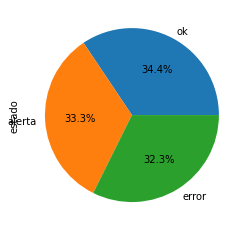

In [ ]:
df_baterias["estado"].value_counts().plot(kind = "pie", autopct='%1.1f%%')

Se verifica que la *variable target* se encuentra balanceda, por lo tanto no hay que aplicar técnicas de remuestreo como **SMOTE** o **RESAMPLE**.

In [ ]:
est = df_baterias[['estado', 'estado_id', 'vcd']]
est2=est.groupby(by=['estado', 'estado_id']).count()

# se debe realizar 2 veces para el indice quede creado correctamente
est2.reset_index(level=0, inplace=True)
est2.reset_index(level=0, inplace=True)


est2

,estado_id,estado,vcd
0,1,alerta,178
1,2,error,173
2,0,ok,184


El estado_id es la representación númerica (una especie de código) de la variable estado la cuál es la descripción o la representación categorica del estado_id.


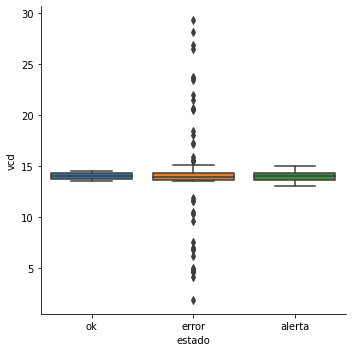

In [ ]:
sns.catplot(x = "estado", y = "vcd", data = df_baterias, kind = "box")

la variable de voltaje no presenta dispersión en sus diferentes estados, en el estado de **error** se evidencian unos datos **Outliers** (datos que presentan un comportamiento diferente al resto de los datos), pero no se borran dado que el objetivo es detectar fallos y estos suelen presentarse en los datos atípicos.

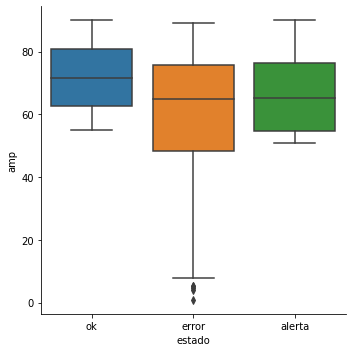

In [ ]:
sns.catplot(x = "estado", y = "amp", data = df_baterias, kind = "box")

Para la corriente se presenta una distribución normal símetrica para el estado de ok y alerta, y una distribución de skewness negativa. Al igual que en el voltaje la corriente presenta datos atípicos en el estado error, estos valores se conservan por el tema de que es en esos datos atípicos dondé se pueden concentrar las fallas (errores). el amperaje presenta dispersión pero no  es tan impactante.

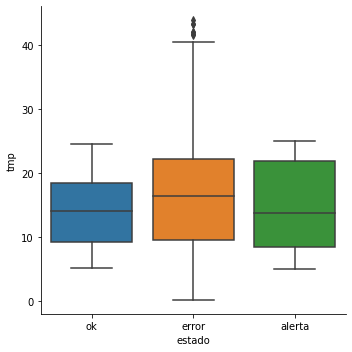

In [ ]:
sns.catplot(x = "estado", y = "tmp", data = df_baterias, kind = "box")

La temperatura para el estado ok presenta una distribución normal , para el estado error se presenta una distribución asímetrica negativa, y para el estado de alerta se presenta una distribución positiva, los datos presentan dispersión.

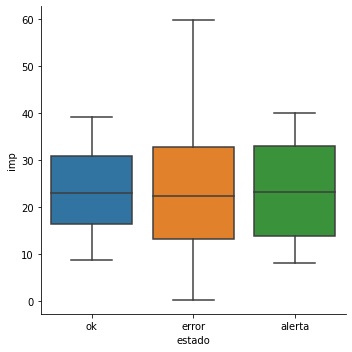

In [ ]:
sns.catplot(x = "estado", y = "imp", data = df_baterias, kind = "box")

Para la resistencia en el estado ok, error y alerta presentan una distribución normal (media=mediana=moda)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f338b81eac8>,
      dtype=object)

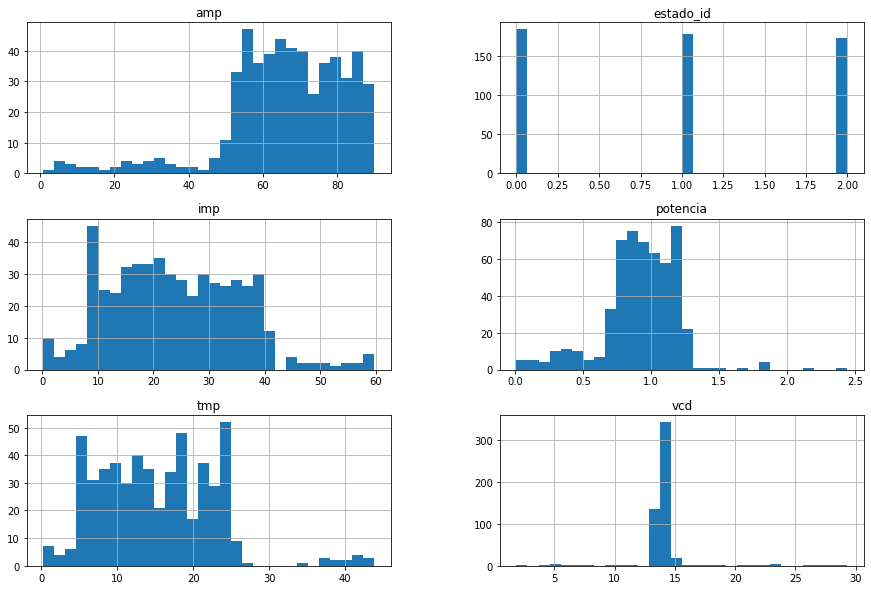

In [ ]:
df_baterias.hist(bins=30, figsize=(15, 10))

El comportamiento general de las diferentes variables el amperaje presenta una distribución asímetrica positiva, la resistencia presenta una distribución normal con una cola hacia la dercha, la potencia presenta una distribución un poco sesgada hacia la izquierda, el voltaje de corriente directa se centra en 15.

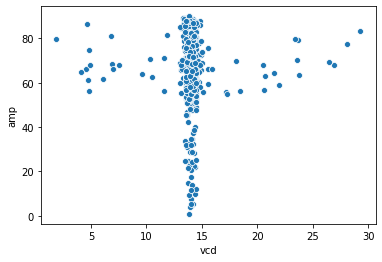

In [ ]:
sns.scatterplot(x="vcd",y="amp" ,data=df_baterias)

Si partimos de que el voltaje de corriente directa (vdc) es nominal, del anterior gráfico se puede deducir que el estado normal de voltaje es 15, los demás valores son posibles fallas. También se puede interpretar que la carga varía mucho, donde el  mayor consumo se da a partir de 40 amperios.

**Correlación de Datos**

Para hacer uso de la correlación de pearson se deben evaluar las suposiciones de normalidad de la distribución y homogeneidad de la varianza 

In [ ]:
# lo usamos para descartar pearson
#prueba que la hipótesis nula de que la asimetría de la población de la que se extrajo la muestra es la misma que la de una distribución normal correspondiente.
print(skewtest(df_baterias["vcd"]))
print(skewtest(df_baterias["amp"]))

#prueba que la hipótesis nula de que todas las muestras de entrada provienen de poblaciones con varianzas iguales, me dice si las varaianzas son homogeneas o no
print(levene(df_baterias["vcd"],df_baterias["amp"]))


#Un valor p menor significa que hay evidencia más fuerte a favor de la hipótesis alternativa

SkewtestResult(statistic=8.684791578284988, pvalue=3.7943745138759845e-18)
SkewtestResult(statistic=-9.535732381635388, pvalue=1.4883129185978712e-21)
LeveneResult(statistic=560.4567392997341, pvalue=6.122716476598878e-100)


Observamos que sí hay una relación lineal entre las variables. Sin embargo, los tests de uniformidad de la distribución y homogeneidad arrojan resultados negativos. Por lo tanto, la prueba de correlación apropiada para usar sería una prueba no paramétrica como la correlación de Spearman o de Kendall.

**Correlación Kendall**

In [ ]:
corr_k = df_baterias.corr(method = "kendall") 
corr_k.style.background_gradient(cmap='coolwarm')

,vcd,amp,tmp,imp,estado_id,potencia
vcd,1.000000,-0.055550,-0.004990,-0.044301,-0.030019,0.136462
amp,-0.055550,1.000000,0.003018,0.045655,-0.195046,0.808787
tmp,-0.004990,0.003018,1.000000,0.045193,0.051855,-0.011064
imp,-0.044301,0.045655,0.045193,1.000000,-0.007686,0.027936
estado_id,-0.030019,-0.195046,0.051855,-0.007686,1.000000,-0.200971
potencia,0.136462,0.808787,-0.011064,0.027936,-0.200971,1.000000


**Correlación de Spearman**

In [ ]:
corr_s = df_baterias.corr(method = "spearman")
corr_s.style.background_gradient(cmap='coolwarm')

,vcd,amp,tmp,imp,estado_id,potencia
vcd,1.000000,-0.085974,-0.008749,-0.064160,-0.039981,0.197248
amp,-0.085974,1.000000,0.003654,0.068178,-0.245945,0.903088
tmp,-0.008749,0.003654,1.000000,0.068798,0.070170,-0.015923
imp,-0.064160,0.068178,0.068798,1.000000,-0.011126,0.043240
estado_id,-0.039981,-0.245945,0.070170,-0.011126,1.000000,-0.246046
potencia,0.197248,0.903088,-0.015923,0.043240,-0.246046,1.000000


Se evidencia que la hipotesis planteda de la potencia se rechaza dado que presenta una alta correlación con el amperaje (corriente) por lo tanto se puede descartar. De resto no se evidencia una alta correlación entre las variables, por lo tanto para desarrollar los modelos se  hace uso de todas las características excepto de potencia y estado_id que está altamente relacionada con la variable target.

# 3. Preprocesamiento de la información

Se elimina la variable estado, ya que es una variable que nos indica lo mismo que la variable estado_id, nos quedamos con la variable de estado_id ya que para la implementación de modelos de Machine learning lo ideal es trabajar con tipos de datos númericos.


una muy buena práctica es hacerle una copia al dataframe por si sucede algo no volverlo a cargar

In [ ]:
df_baterias_p = df_baterias

In [ ]:
del df_baterias_p['estado']
del df_baterias_p['potencia']

In [ ]:
# Se verifica que la variable estado y potencia ya no esté en el dataframe
df_baterias_p.columns

Index(['vcd', 'amp', 'tmp', 'imp', 'estado_id'], dtype='object')

# 4. Implementación modelo de Machine Learning

Se deben separar los arrays, queda uno para  las variables predictoras (X) y otro  para la variable target (y)


In [ ]:
X = df_baterias_p.drop(["estado_id"], axis=1)
y = df_baterias_p['estado_id']

Luego con el dataframe de implementación se separan los datos en entrenamiento (80%) y prueba (20%)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Se escalan los datos para que los algoritmos tengan un mejor rendimiento

In [ ]:
X_train = preprocessing.scale(X_train)
X_test = preprocessing.scale(X_test)

# Funciones para entrenamiento y validación

In [ ]:
#Se crea un diccionario que contendrá cada uno de los mejores modelos obtenidos con el GridSearchCV
best_models = {}

**Función creada para la optimización de hiperparámetros**

Para la evaluación de los modelos se hará uso de la métrica del **recall**, la cuál nos indica la proporción de fallas que se identifican correctamente, sobre el # total de fallas que efectivamente están en el dataset.

In [ ]:
def Grid_Search(parameters,model):
    
    grid_search = GridSearchCV(estimator=model, 
                           scoring='recall_weighted',
                           param_grid=parameters,
                           return_train_score = True,
                           cv = 5,
                           n_jobs = -1,
                           verbose = 2)
    
    grid_search = grid_search.fit(X_train, y_train)
    
    grid_scores = pd.DataFrame(grid_search.cv_results_['params'])
    grid_scores['mean_train_score'] = grid_search.cv_results_['mean_train_score']
    grid_scores['mean_test_score'] = grid_search.cv_results_['mean_test_score']
    
    grid_best_params = grid_search.best_params_
    
    optimised_model = grid_search.best_estimator_
    
    return grid_search, grid_scores, grid_best_params, optimised_model

Se define una función para gráficar la matriz de confusión

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Matriz de confusión sin normalización')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Verdadero')
    plt.xlabel('Predicción')

#1. K vecinos más cercanos

Es un algoritmo de distancias dondé el hiperparámetro a calibrar es la cantidad de vecinos

Se hace uso de las **Curvas de validación** para detectar el rango del hiperparámetro cantidad de vecinos dondé se maximice el accuracy


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Expected n_neighbors > 0. Got 0

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Expected n_neighbors > 0. Got 0

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Expected n_neighbors > 0. Got 0

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for 

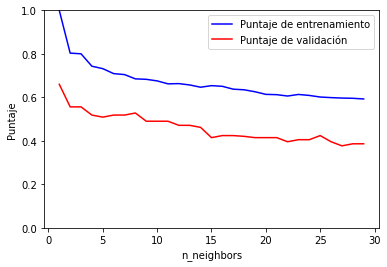

In [ ]:
n_neighbors = np.arange(0, 30)
train_score, val_score = validation_curve(KNeighborsClassifier(), X, y,
                                          'n_neighbors', n_neighbors, cv=10)

plt.plot(n_neighbors, np.median(train_score, 1), color='blue', label='Puntaje de entrenamiento')
plt.plot(n_neighbors, np.median(val_score, 1), color='red', label='Puntaje de validación')
plt.legend(loc='best')
plt.ylim(0, 1)
plt.xlabel('n_neighbors')
plt.ylabel('Puntaje');

Se puede observar que las líneas de entrenamiento y validación se empiezan a estabalizar después de 10 vecinos,se implementa Gridsearch para 10,15 y 20 vecinos, aunque  la diferencia entre ambos puntajes es considerablemnte, por lo que se pueden estar presentando problemas de overfitting

In [ ]:
parameters = {'n_neighbors':[10,15,20]}
knn = KNeighborsClassifier()

grid_search, grid_scores, grid_best_params, optimised_model = Grid_Search(parameters,knn)

best_models[str(type(optimised_model).__name__)] = optimised_model



Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    1.7s finished


In [ ]:
grid_scores

,n_neighbors,mean_train_score,mean_test_score
0,10,0.71,0.64
1,15,0.68,0.62
2,20,0.66,0.58


In [ ]:
optimised_model

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='uniform')

In [ ]:
grid_best_params

{'n_neighbors': 10}

Entrenamos nuevamente con los hiperparámetros del mejor modelo en esto caso con número de vecinos = 10, el promedio del recall es 0.69 para entrenamiento y 0.63 para test, lo cuál no presentá una diferencia considerable y por lo tanto no podríamos hablar de overfitting.

In [ ]:
vmc = KNeighborsClassifier(n_neighbors = 10).fit(X_train,y_train)
y_pred_knn=vmc.predict(X_test)

Evaluamos nuevamente el modelo la medida para la evaluación es el recall.

              precision    recall  f1-score   support

           0       0.71      0.64      0.67        45
           1       0.56      0.67      0.61        36
           2       0.96      0.85      0.90        26

    accuracy                           0.70       107
   macro avg       0.74      0.72      0.73       107
weighted avg       0.72      0.70      0.71       107

Matriz de confusión sin normalización
[[29 16  0]
 [11 24  1]
 [ 1  3 22]]


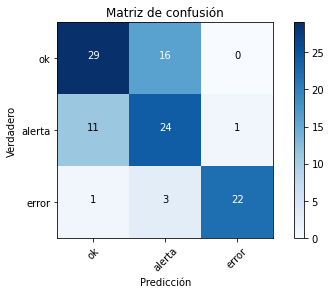

In [ ]:
cnf_matrix = confusion_matrix(y_test, y_pred_knn, labels=[0,1,2])
np.set_printoptions(precision=2)

print (classification_report(y_test, y_pred_knn))

# Gráfico personalizado matriz de confusión
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['ok','alerta','error'],normalize= False,  title='Matriz de confusión')


Los resultados del modelo es decir el comportamiento del recall para la clase de interés que es la 2 (error) presenta un comportamiento bueno  del 85%, sin embargo se prueban otro modelos, para observar cuál se comporta mejor.

#2. Árboles de Decisión

**Curva de Validación**

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-t

Text(0, 0.5, 'Puntaje')

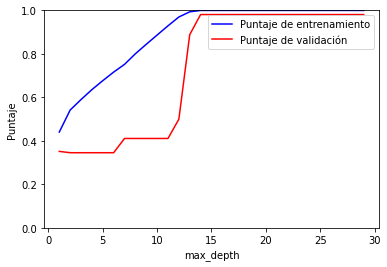

In [ ]:
max_depth = np.arange(0, 30)
train_score, val_score = validation_curve(DecisionTreeClassifier(), X, y,
                                          'max_depth', max_depth, cv=10)

plt.plot(max_depth, np.median(train_score, 1), color='blue', label='Puntaje de entrenamiento')
plt.plot(max_depth, np.median(val_score, 1), color='red', label='Puntaje de validación')
plt.legend(loc='best')
plt.ylim(0, 1)
plt.xlabel('max_depth')
plt.ylabel('Puntaje')

el valor del hiperparámetro max depth, presenta sobreajuste (overfitting) con profundidades mayores a 15, por lo tanto se busca el mejor modelo entre 10 y 15 qué es dondé se maximiza el accuracy.

In [ ]:
%%time

parameters = {'criterion':["gini", "entropy"],
              'max_depth':[10,12,14, None]}

dtc = DecisionTreeClassifier()

grid_search, grid_scores, grid_best_params, optimised_model = Grid_Search(parameters,dtc)

best_models[str(type(optimised_model).__name__)] = optimised_model

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


CPU times: user 109 ms, sys: 24.9 ms, total: 134 ms
Wall time: 1.45 s


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    1.4s finished


In [ ]:
grid_scores

,criterion,max_depth,mean_train_score,mean_test_score
0,gini,10.00,0.85,0.79
1,gini,12.00,0.94,0.87
2,gini,14.00,1.00,0.98
3,gini,nan,1.00,0.98
4,entropy,10.00,0.85,0.79
5,entropy,12.00,0.94,0.87
6,entropy,14.00,1.00,0.98
7,entropy,nan,1.00,0.98


Entrenamos nuevamente el modelo con los mejores hiperparámetros

In [ ]:
grid_best_params

{'criterion': 'gini', 'max_depth': 14}

In [ ]:
ad = DecisionTreeClassifier(criterion='gini',max_depth=14).fit(X_train,y_train)
y_pred_dtc = ad.predict(X_test)


Evaluemos nuevamente con el recall y la matriz de confusión

              precision    recall  f1-score   support

           0       0.82      0.69      0.75        45
           1       0.55      0.44      0.49        36
           2       0.62      0.96      0.76        26

    accuracy                           0.67       107
   macro avg       0.66      0.70      0.67       107
weighted avg       0.68      0.67      0.66       107

Matriz de confusión sin normalización
[[31 12  2]
 [ 7 16 13]
 [ 0  1 25]]


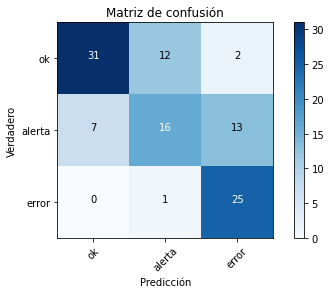

In [ ]:
cnf_matrix = confusion_matrix(y_test, y_pred_dtc, labels=[0,1,2])
np.set_printoptions(precision=2)

print (classification_report(y_test, y_pred_dtc))

# Gráfico personalizado matriz de confusión
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['ok','alerta','error'],normalize= False,  title='Matriz de confusión')

Los árboles de decisión tuvieron un mejor desempeño que el algoritmo de k- vecinos más cercanos, brindando en promedio un recall del 96%, y para nuestra clase de interés del 96%, de un modelo tan perfecto hay que dudar pero para eso se usa el dataset de validación.

#3. Máquinas de soporte vectorial

**SVC - Lineal**

In [ ]:
%%time
parameters = {'C':[0.001, 0.01, 0.1, 1,10],
              'loss':['hinge', 'squared_hinge']}

svc = LinearSVC(random_state = 0)

grid_search, grid_scores, grid_best_params, optimised_model = Grid_Search(parameters,svc)

best_models[str(type(optimised_model).__name__)] = optimised_model

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


CPU times: user 281 ms, sys: 6.43 ms, total: 287 ms
Wall time: 599 ms


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.6s finished


In [ ]:
grid_scores

,C,loss,mean_train_score,mean_test_score
0,0.00,hinge,0.42,0.38
1,0.00,squared_hinge,0.42,0.39
2,0.01,hinge,0.40,0.38
3,0.01,squared_hinge,0.42,0.39
4,0.10,hinge,0.39,0.38
5,0.10,squared_hinge,0.42,0.39
6,1.00,hinge,0.41,0.37
7,1.00,squared_hinge,0.42,0.39
8,10.00,hinge,0.40,0.35
9,10.00,squared_hinge,0.42,0.38


Esté modelo nos arroja un recall bajo, por lo tanto no es buen clasificador, ya que se evidencia que  la frontera de decisión no puede ser lineal.

**SVM - kernel**

In [ ]:
parameters = {'C':[1,2,3]}

msp =  svm.SVC(kernel='rbf')

grid_search, grid_scores, grid_best_params, optimised_model = Grid_Search(parameters,msp)

best_models[str(type(optimised_model).__name__)] = optimised_model

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    1.2s finished


In [ ]:
grid_scores

,C,mean_train_score,mean_test_score
0,1,0.77,0.71
1,2,0.78,0.71
2,3,0.79,0.73


Esté modelo nos arroja un recall aceptable del 79%, esté es inferior a los de los árboles de decisión.

In [ ]:
grid_best_params

{'C': 3}

Entrenamos el modelo nuevamente con los mejores hiperparámetros

In [ ]:
ms = svm.SVC(C=3).fit(X_train,y_train)
y_pred_svm = ms.predict(X_test)


Se evidencia que las máquinas de soporte vectorial presentan también un muy buen desempeño en la variable de interés 85% pero sigue siendo mejor los árboles de decisión -> detectar fallar (código 2)

#4. Algoritmo Perceptron Multicapa


In [ ]:
%%time
parameters = {'hidden_layer_sizes':[(100,),(5,5), (10,10)],
              'activation':['relu','tanh'],
              'solver': ['lbfgs', 'sgd', 'adam']}

m_perc = MLPClassifier(random_state=0)

grid_search, grid_scores, grid_best_params, optimised_model = Grid_Search(parameters, m_perc)

best_models[str(type(optimised_model).__name__)] = optimised_model

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    6.9s


CPU times: user 551 ms, sys: 21.9 ms, total: 573 ms
Wall time: 17.2 s


[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   17.0s finished
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [ ]:
grid_scores

,activation,hidden_layer_sizes,solver,mean_train_score,mean_test_score
0,relu,"(100,)",lbfgs,1.00,0.80
1,relu,"(100,)",sgd,0.51,0.47
2,relu,"(100,)",adam,0.79,0.68
3,relu,"(5, 5)",lbfgs,0.85,0.79
4,relu,"(5, 5)",sgd,0.30,0.29
5,relu,"(5, 5)",adam,0.55,0.50
6,relu,"(10, 10)",lbfgs,0.96,0.82
7,relu,"(10, 10)",sgd,0.47,0.44
8,relu,"(10, 10)",adam,0.67,0.61
9,tanh,"(100,)",lbfgs,1.00,0.68


In [ ]:
grid_best_params

{'activation': 'relu', 'hidden_layer_sizes': (10, 10), 'solver': 'lbfgs'}

Para esté caso el mejor modelo es el que tiene una función de activación relu, 100 neuronas en la última capa y el optimizador lbfgs, es el mejor, pero al parecer el modelo está presentando overfitting (diferencia entre score de train y test es considerablemente mayor.). se prueban otros algoritmos.

#5. Métodos de ensamble

**Curva de validación para Random Forest**

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-t

Text(0, 0.5, 'Puntaje')

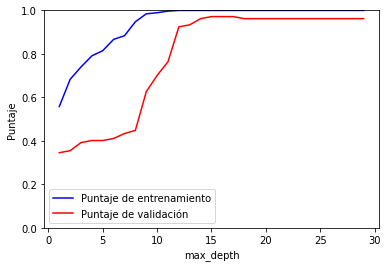

In [ ]:
max_depth = np.arange(0, 30)
train_score, val_score = validation_curve(RandomForestClassifier(random_state=0), X, y,
                                          'max_depth', max_depth, cv=10)

plt.plot(max_depth, np.median(train_score, 1), color='blue', label='Puntaje de entrenamiento')
plt.plot(max_depth, np.median(val_score, 1), color='red', label='Puntaje de validación')
plt.legend(loc='best')
plt.ylim(0, 1)
plt.xlabel('max_depth')
plt.ylabel('Puntaje')

Al igual que en los árboles de decisión cuando la profundidad de los estimadores (árboles de decisión) es mayor a 15 se presenta overfitting.


**Random Forest**

In [ ]:
%%time
parameters = {'max_depth':[5,7,11, None],
              'bootstrap':[True, False],
              'min_samples_split':[2, 3, 10],
              'criterion':["gini", "entropy"],
              'n_estimators':[100, 500, 1000]}

rf = RandomForestClassifier(random_state=0)

grid_search, grid_scores, grid_best_params, optimised_model = Grid_Search(parameters,rf)

best_models[str(type(optimised_model).__name__)] = optimised_model

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  8.7min


CPU times: user 3.16 s, sys: 97.4 ms, total: 3.26 s
Wall time: 9min 58s


[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed: 10.0min finished


In [ ]:
grid_scores

,bootstrap,criterion,max_depth,min_samples_split,n_estimators,mean_train_score,mean_test_score
0,True,gini,5.00,2,100,0.77,0.70
1,True,gini,5.00,2,500,0.78,0.73
2,True,gini,5.00,2,1000,0.78,0.72
3,True,gini,5.00,3,100,0.77,0.70
4,True,gini,5.00,3,500,0.78,0.73
...,...,...,...,...,...,...,...
139,False,entropy,nan,3,500,1.00,0.98
140,False,entropy,nan,3,1000,1.00,0.98
141,False,entropy,nan,10,100,1.00,0.98
142,False,entropy,nan,10,500,1.00,0.98


Encontramos muy buenos valores promedios en el recall, tanto en entrenamiento como en prueba, estos valores serán validados con el set de validación.

In [ ]:
grid_best_params

{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': None,
 'min_samples_split': 2,
 'n_estimators': 100}

              precision    recall  f1-score   support

           0       0.82      0.69      0.75        45
           1       0.55      0.44      0.49        36
           2       0.62      0.96      0.76        26

    accuracy                           0.67       107
   macro avg       0.66      0.70      0.67       107
weighted avg       0.68      0.67      0.66       107

Matriz de confusión sin normalización
[[31 12  2]
 [ 7 16 13]
 [ 0  1 25]]


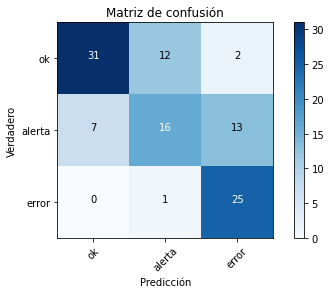

In [ ]:
rfb = RandomForestClassifier(random_state=0,bootstrap=True,criterion='gini',max_depth= None, min_samples_split=2,n_estimators=500).fit(X_train,y_train)
y_pred_rf= rfb.predict(X_test)

cnf_matrix = confusion_matrix(y_test, y_pred_rf, labels=[0,1,2])
np.set_printoptions(precision=2)

print (classification_report(y_test, y_pred_rf))

# Gráfico personalizado matriz de confusión
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['ok','alerta','error'],normalize= False,  title='Matriz de confusión')

Esté algorimo tamién presenta un muy bien comportamiento en el recall en la variable target con el valor 2, da resultados similares a los árboles de decisión pero el tiempo de  entrenamiento es mayor.

**Ada Boost**

**Curva de validación para Ada Boost**

Text(0, 0.5, 'Puntaje')

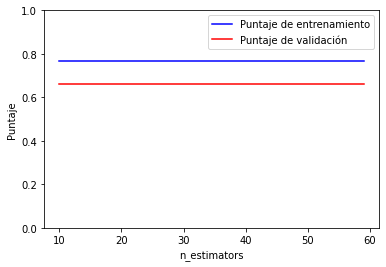

In [ ]:
n_estimators = np.arange(10, 60)
train_score, val_score = validation_curve(AdaBoostClassifier(random_state=0), X, y,
                                          'n_estimators', n_estimators, cv=10)

plt.plot(n_estimators, np.median(train_score, 1), color='blue', label='Puntaje de entrenamiento')
plt.plot(n_estimators, np.median(val_score, 1), color='red', label='Puntaje de validación')
plt.legend(loc='best')
plt.ylim(0, 1)
plt.xlabel('n_estimators')
plt.ylabel('Puntaje')

Se evidencia que después de 10 estimadores se estabiliza el comportamiento del recall, que independiente del número de estimadores va  atener el mismo comportamiento en el score.

In [ ]:
parameters = {'n_estimators': [10, 15, 20]}

adab = AdaBoostClassifier(random_state=0)

grid_search, grid_scores, grid_best_params, optimised_model = Grid_Search(parameters, adab)

best_models[str(type(optimised_model).__name__)] = optimised_model

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.4s finished


In [ ]:
grid_scores

,n_estimators,mean_train_score,mean_test_score
0,10,0.76,0.75
1,15,0.74,0.73
2,20,0.76,0.75


Tiene en promedio un recall aceptable del 75%.

Se vuelve a entrenar el modelo con los mejores hiperparámetros 

In [ ]:
grid_best_params

{'n_estimators': 10}

Se vuelve a entrenar y a evaluar el algoritmo con los mejores hiperparámetros

              precision    recall  f1-score   support

           0       0.74      0.87      0.80        45
           1       0.60      0.17      0.26        36
           2       0.57      0.96      0.71        26

    accuracy                           0.65       107
   macro avg       0.63      0.66      0.59       107
weighted avg       0.65      0.65      0.60       107

Matriz de confusión sin normalización
[[39  4  2]
 [13  6 17]
 [ 1  0 25]]


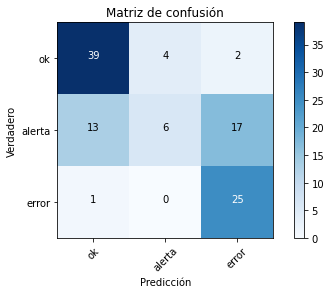

In [ ]:
adb = AdaBoostClassifier(random_state=0,n_estimators=10).fit(X_train,y_train)
y_pred_adb= adb.predict(X_test)

cnf_matrix = confusion_matrix(y_test, y_pred_adb, labels=[0,1,2])
np.set_printoptions(precision=2)

print (classification_report(y_test, y_pred_adb))

# Gráfico personalizado matriz de confusión
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['ok','alerta','error'],normalize= False,  title='Matriz de confusión')

Tiene un comportamiento del recall en nuestra clase de interés el error, tiene un comportamiento similar a random forest y a los árboles de decisión.

**Gradient Boost**

**Curva de validación para gradient boost**

Text(0, 0.5, 'Puntaje')

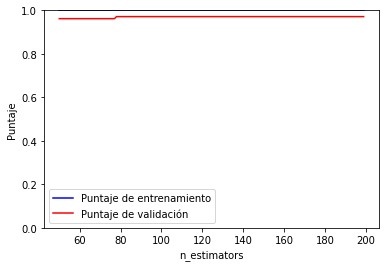

In [ ]:
n_estimators = np.arange(50, 200)
train_score, val_score = validation_curve(GradientBoostingClassifier(random_state=0), X, y,
                                          'n_estimators', n_estimators, cv=10)

plt.plot(n_estimators, np.median(train_score, 1), color='blue', label='Puntaje de entrenamiento')
plt.plot(n_estimators, np.median(val_score, 1), color='red', label='Puntaje de validación')
plt.legend(loc='best')
plt.ylim(0, 1)
plt.xlabel('n_estimators')
plt.ylabel('Puntaje')

Cómo son pocos features se prueba con profundidades pequeñas

In [ ]:
%%time
parameters = {'max_depth':[3,4,6, None],
              'subsample':[0.7,0.6, 0.8],
              'n_estimators':[50, 80, 120]}

gb= GradientBoostingClassifier(random_state=0)


grid_search, grid_scores, grid_best_params, optimised_model = Grid_Search(parameters, gb)

best_models[str(type(optimised_model).__name__)] = optimised_model


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   45.4s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   55.2s finished


CPU times: user 1.04 s, sys: 51 ms, total: 1.09 s
Wall time: 55.5 s


In [ ]:
grid_scores

,max_depth,n_estimators,subsample,mean_train_score,mean_test_score
0,3.00,50,0.70,1.00,0.98
1,3.00,50,0.60,1.00,0.98
2,3.00,50,0.80,1.00,0.98
3,3.00,80,0.70,1.00,0.99
4,3.00,80,0.60,1.00,0.99
5,3.00,80,0.80,1.00,0.99
6,3.00,120,0.70,1.00,0.99
7,3.00,120,0.60,1.00,0.99
8,3.00,120,0.80,1.00,0.99
9,4.00,50,0.70,1.00,0.98


Se entrena el modelo nuevamente con los mejores hiperparámetros

In [ ]:
grid_best_params

{'max_depth': 3, 'n_estimators': 80, 'subsample': 0.7}

Se vuelve a entrenar y a evaluar el algoritmo con los mejores hiperparámetros

              precision    recall  f1-score   support

           0       0.79      0.69      0.74        45
           1       0.52      0.36      0.43        36
           2       0.58      0.96      0.72        26

    accuracy                           0.64       107
   macro avg       0.63      0.67      0.63       107
weighted avg       0.65      0.64      0.63       107

Matriz de confusión sin normalización
[[31 12  2]
 [ 7 13 16]
 [ 1  0 25]]


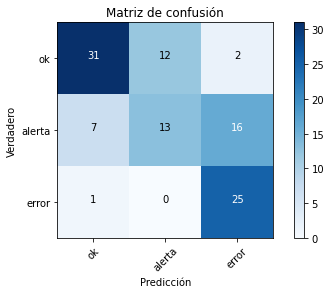

In [ ]:
gbm = GradientBoostingClassifier(random_state=0,n_estimators=100).fit(X_train,y_train)
y_pred_gb= gbm.predict(X_test)

cnf_matrix = confusion_matrix(y_test, y_pred_gb, labels=[0,1,2])
np.set_printoptions(precision=2)

print (classification_report(y_test, y_pred_gb))

# Gráfico personalizado matriz de confusión
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['ok','alerta','error'],normalize= False,  title='Matriz de confusión')

El algoritmo gradient boosting se comporta igual de bien en nuestra clase objetivo de error con un recall del 96%

**Extra Tree Classifier**

Text(0, 0.5, 'Puntaje')

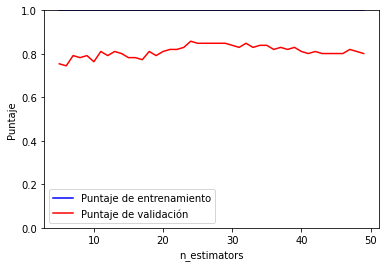

In [ ]:
n_estimators = np.arange(5, 50)
train_score, val_score = validation_curve(ExtraTreesClassifier(random_state=0), X, y,
                                          'n_estimators', n_estimators, cv=10)

plt.plot(n_estimators, np.median(train_score, 1), color='blue', label='Puntaje de entrenamiento')
plt.plot(n_estimators, np.median(val_score, 1), color='red', label='Puntaje de validación')
plt.legend(loc='best')
plt.ylim(0, 1)
plt.xlabel('n_estimators')
plt.ylabel('Puntaje')

El scoring mejora un poco con un rango de estimadores entre 20 y 35.

In [ ]:
parameters = {'max_depth':[4, 8, None],
              'min_samples_split':[2, 8, 15],
              'criterion':["gini", "entropy"],
              'n_estimators':[10, 30, 45]}

etc=ExtraTreesClassifier(random_state=0)

grid_search, grid_scores, grid_best_params, optimised_model = Grid_Search(parameters, etc)

best_models[str(type(optimised_model).__name__)] = optimised_model

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:   10.0s finished


In [ ]:
grid_scores

,criterion,max_depth,min_samples_split,n_estimators,mean_train_score,mean_test_score
0,gini,4.00,2,10,0.71,0.64
1,gini,4.00,2,30,0.73,0.67
2,gini,4.00,2,45,0.77,0.70
3,gini,4.00,8,10,0.71,0.65
4,gini,4.00,8,30,0.73,0.67
5,gini,4.00,8,45,0.76,0.70
6,gini,4.00,15,10,0.71,0.65
7,gini,4.00,15,30,0.73,0.67
8,gini,4.00,15,45,0.76,0.70
9,gini,8.00,2,10,0.87,0.78


Se evidencia overfitting, ya que la diferencia entre el recall en entrenamiento y prueba es considerablamente alta, se podrían aplicar técnicas de **Regularización cómo Ridge o lasso**, pero se probarán otros algoritmos, que no presenten esté problema

Se entrena y se valida nuevamente el modelo con los mejores hiperparámetros encontrados.

In [ ]:
grid_best_params

{'criterion': 'entropy',
 'max_depth': None,
 'min_samples_split': 8,
 'n_estimators': 45}

              precision    recall  f1-score   support

           0       0.80      0.73      0.77        45
           1       0.58      0.50      0.54        36
           2       0.69      0.92      0.79        26

    accuracy                           0.70       107
   macro avg       0.69      0.72      0.70       107
weighted avg       0.70      0.70      0.69       107

Matriz de confusión sin normalización
[[33 11  1]
 [ 8 18 10]
 [ 0  2 24]]


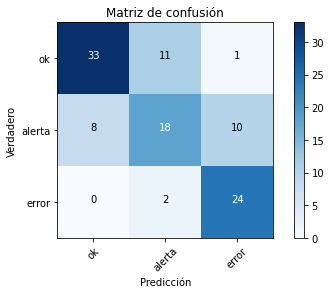

In [ ]:
etcm = ExtraTreesClassifier(random_state=0,criterion='entropy',max_depth=None,min_samples_split=2,n_estimators=30).fit(X_train,y_train)
y_pred_etc= etcm.predict(X_test)

cnf_matrix = confusion_matrix(y_test, y_pred_etc, labels=[0,1,2])
np.set_printoptions(precision=2)

print (classification_report(y_test, y_pred_etc))

# Gráfico personalizado matriz de confusión
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['ok','alerta','error'],normalize= False,  title='Matriz de confusión')

Es un modelo que presenta buen recall en el código = 2, pero se descarta por el tema del overfitting.

#6. GaussianNB

In [ ]:
%%time
parameters = {'var_smoothing': [1e-09,1e-20,1e-30]}
gnb= GaussianNB()

grid_search, grid_scores, grid_best_params, optimised_model = Grid_Search(parameters, gnb)

best_models[str(type(optimised_model).__name__)] = optimised_model

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


CPU times: user 62.8 ms, sys: 22.9 ms, total: 85.7 ms
Wall time: 1.14 s


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    1.1s finished


In [ ]:
grid_scores

,var_smoothing,mean_train_score,mean_test_score
0,0.00,0.68,0.65
1,0.00,0.68,0.65
2,0.00,0.68,0.65


In [ ]:
grid_best_params

{'var_smoothing': 1e-09}

Es un algoritmo que obtiene un scoring Aceptable pero hay otros mejores que tienen un recall más alto.

#7. Label Propagation

In [ ]:
%%time
parameters = {'kernel': ['rbf','knn'],
              'n_neighbors': [4,6,8]}
lpm = LabelPropagation()

grid_search, grid_scores, grid_best_params, optimised_model = Grid_Search(parameters, lpm)

best_models[str(type(optimised_model).__name__)] = optimised_model

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    1.4s finished


In [ ]:
grid_scores

,kernel,n_neighbors,mean_train_score,mean_test_score
0,rbf,4,1.00,0.69
1,rbf,6,1.00,0.69
2,rbf,8,1.00,0.69
3,knn,4,0.77,0.65
4,knn,6,0.74,0.65
5,knn,8,0.71,0.64


También presenta problemas de overfitting, se descarta.

#8. Clasificador Ridge

In [ ]:
parameters = {'alpha': [1.2, 1.3, 1.4],
              'normalize': [False,True]}

rcl = RidgeClassifier(random_state=0)

grid_search, grid_scores, grid_best_params, optimised_model = Grid_Search(parameters, rcl)

best_models[str(type(optimised_model).__name__)] = optimised_model

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    1.3s finished


In [ ]:
grid_scores

,alpha,normalize,mean_train_score,mean_test_score
0,1.20,False,0.42,0.39
1,1.20,True,0.41,0.38
2,1.30,False,0.42,0.39
3,1.30,True,0.41,0.38
4,1.40,False,0.42,0.39
5,1.40,True,0.41,0.38


Esté algoritmo también se descarté ya que presenta un scoring bajo

# Mejores resultados

In [ ]:
for model in best_models:
    
    estimator = best_models[str(model)]
    y_pred = best_models[str(model)].predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    clsf_report = pd.DataFrame(report).transpose()
    print(model)
    print(clsf_report)
    print()

KNeighborsClassifier
              precision  recall  f1-score  support
0                  0.71    0.64      0.67    45.00
1                  0.56    0.67      0.61    36.00
2                  0.96    0.85      0.90    26.00
accuracy           0.70    0.70      0.70     0.70
macro avg          0.74    0.72      0.73   107.00
weighted avg       0.72    0.70      0.71   107.00

DecisionTreeClassifier
              precision  recall  f1-score  support
0                  0.82    0.69      0.75    45.00
1                  0.55    0.44      0.49    36.00
2                  0.62    0.96      0.76    26.00
accuracy           0.67    0.67      0.67     0.67
macro avg          0.66    0.70      0.67   107.00
weighted avg       0.68    0.67      0.66   107.00

LinearSVC
              precision  recall  f1-score  support
0                  0.57    0.60      0.59    45.00
1                  0.18    0.06      0.09    36.00
2                  0.29    0.54      0.37    26.00
accuracy           0.40   

# Método de ensamble por votación

In [ ]:
models_list = [(k,v) for k,v in best_models.items()]
eclf = VotingClassifier(estimators=models_list, voting='hard',n_jobs=-1)
eclf.fit(X_train, y_train)
best_models[type(eclf).__name__] = eclf

In [ ]:
for model in best_models:
    estimator = best_models[str(model)]
    y_pred = estimator.predict(X_test)
    print(type(estimator).__name__, round(recall_score(y_test, y_pred,average='weighted'),2))

KNeighborsClassifier 0.7
DecisionTreeClassifier 0.67
LinearSVC 0.4
SVC 0.68
MLPClassifier 0.63
RandomForestClassifier 0.67
AdaBoostClassifier 0.69
GradientBoostingClassifier 0.64
ExtraTreesClassifier 0.66
LabelPropagation 0.66
GaussianNB 0.64
RidgeClassifier 0.4
VotingClassifier 0.72


#Arquitectura de un perceptron multicapa

Se importa tensorflow 2 para construir la arquitectura de la red neuronal

In [ ]:
from tensorflow import keras
%tensorflow_version 2.x

Se limpia la sesión de keras para liberar memoria

In [ ]:
keras.backend.clear_session()

In [ ]:
X_train.shape

(428, 4)

Se crea una red neuronal con una capa de inicio de 50 neuronas y función de activación selu, las capas son densas lo que nos indica que es una arquitectura de perceptron multicapa, y en la últma capa se hace uso de la función e activación softmax ya que la tarea es de clasificación multiclase.


In [ ]:
model= keras.models.Sequential([
                         keras.layers.Dense(50,activation='selu',kernel_initializer='he_uniform',input_shape=(4,)),
                         keras.layers.Dense(25,activation='selu',kernel_initializer='he_uniform'),
                         keras.layers.Dense(10,activation='selu',kernel_initializer='he_uniform'),
                         keras.layers.Dense(1,activation='softmax')
])

In [ ]:
 model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
pmc=model.fit(X_train,y_train,epochs=100)

Epoch 1/100
14/14 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.3318
Epoch 2/100
14/14 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.3318
Epoch 3/100
14/14 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.3318
Epoch 4/100
14/14 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.3318
Epoch 5/100
14/14 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.3318
Epoch 6/100
14/14 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.3318
Epoch 7/100
14/14 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.3318
Epoch 8/100
14/14 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.3318
Epoch 9/100
14/14 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.3318
Epoch 10/100
14/14 [==============================] - 0s 1ms/step - loss:

In [ ]:
model.evaluate(X_test,y_test)

4/4 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - accuracy: 0.3271


[0.0, 0.32710281014442444]

En conclusión está arquitectura da resultados muy bajos y es superado por otros modelos de Machine learning

# Selección el mejor modelo

In [ ]:
best_model = best_models['VotingClassifier']

In [ ]:
best_model

VotingClassifier(estimators=[('KNeighborsClassifier',
                              KNeighborsClassifier(algorithm='auto',
                                                   leaf_size=30,
                                                   metric='minkowski',
                                                   metric_params=None,
                                                   n_jobs=None, n_neighbors=10,
                                                   p=2, weights='uniform')),
                             ('DecisionTreeClassifier',
                              DecisionTreeClassifier(ccp_alpha=0.0,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=14,
                                                     max_features=None,
                                                     max_leaf_nodes=None,
                                 

El algoritmo elegido son los árboles de decisón, ya que presenta un buen recall en el código = 2 

**Preprocesamiento del Dataset de Validación**

In [ ]:
del df_baterias_val['estado']


In [ ]:
df_baterias_val.columns

Index(['vcd', 'amp', 'tmp', 'imp', 'estado_id'], dtype='object')

In [ ]:
X_val = df_baterias_val.drop(["estado_id"], axis=1)
y_val = df_baterias_val['estado_id']


In [ ]:
X_val = preprocessing.scale(X_val)

Predicción con el modelo elegido

In [ ]:
y_pred_dtc_val = ad.predict(X_val)

In [ ]:
y_pred_dtc_val

array([0, 2, 0, 0, 0, 2, 2, 2, 0, 0, 0, 1, 1, 2, 0, 0, 2, 2, 2, 1, 2, 2,
       1, 1, 2, 2, 2, 2, 0, 0, 2, 2, 0, 2, 2, 0, 2, 2, 0, 0, 2, 0, 1, 2,
       1, 2, 0, 0, 1, 1, 1, 2, 0, 0, 2, 0, 2, 2, 0, 1])

Evaluación en el set de datos de validación

In [ ]:
df_baterias_val['y_pred']=y_pred_dtc_val

In [ ]:
def asignar(df):
    if df['y_pred'] == df['estado_id']:
        val = 1
    else:
        val = 0
    return val

In [ ]:
df_baterias_val['aux']= df_baterias_val.apply(asignar, axis=1)

In [ ]:
df_baterias_val.head(60)

,vcd,amp,tmp,imp,estado_id,y_pred,aux
100,13.66,81.18,6.70,9.96,0,0,1
321,13.95,75.22,26.52,26.47,2,2,1
432,14.67,83.61,15.28,13.51,1,0,0
153,13.73,68.43,6.74,10.98,0,0,1
199,13.87,82.84,16.69,35.75,0,0,1
583,13.89,70.99,19.93,39.89,1,2,0
212,23.53,88.50,13.12,28.47,2,2,1
246,7.82,73.34,16.25,8.87,2,2,1
173,13.95,82.57,23.30,33.13,0,0,1
405,13.38,77.95,16.99,26.54,1,0,0


In [ ]:
df_baterias_val.aux.sum()/60

0.65

En el set de datos ed validación que son datos que el modelo nunca ha visto nos da una precisión del 65%